### 1.1 Import all the required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from PIL import Image
from keras.utils.vis_utils import plot_model
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

import glob
from gtts import gTTS
from playsound import playsound
from IPython import display
import random

import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS

import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### 2.1 Import the dataset and read image & captions into two separate variables

In [20]:
images='images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


### 2.2 Create a list which contains all the captions & path

In [24]:
img_path = 'images/'

all_img_id = [] #store all the image id here
all_img_vector = [] #store all the image path here
annotations = [] #store all the captions here

with open('captions.txt' , 'r') as fo:
  next(fo) #to skip the heading
  for line in fo :
    split_arr = line.split(',')
    all_img_id.append(split_arr[0])
    annotations.append(split_arr[1].rstrip('\n.')) #removing out the \n.
    all_img_vector.append(img_path+split_arr[0])

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,images/1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,images/997722733_0cb5439472.jpg,A man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,images/997722733_0cb5439472.jpg,A rock climber in a red shirt


### 2.3 Visualise the top 30 occuring words in the captions

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Count')

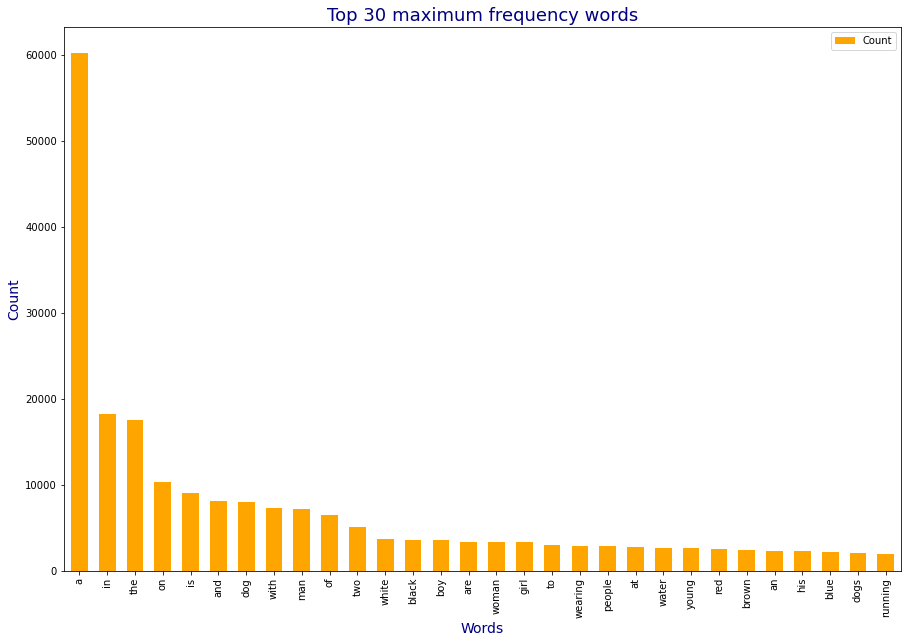

In [29]:
#Create the vocabulary & the counter for the captions

vocabulary = [word.lower() for line in annotations for word in line.split()]
val_count = Counter(vocabulary) 

#Visualise the top 30 occuring words in the captions

for word, count in val_count.most_common(30):
  print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word', y='Count', width=0.6, color='orange', figsize=(15, 10))
plt.title("Top 30 maximum frequency words", fontsize = 18, color= 'navy')
plt.xlabel("Words", fontsize = 14, color= 'navy')
plt.ylabel("Count", fontsize = 14, color= 'navy')


### Visualize the images and captions together

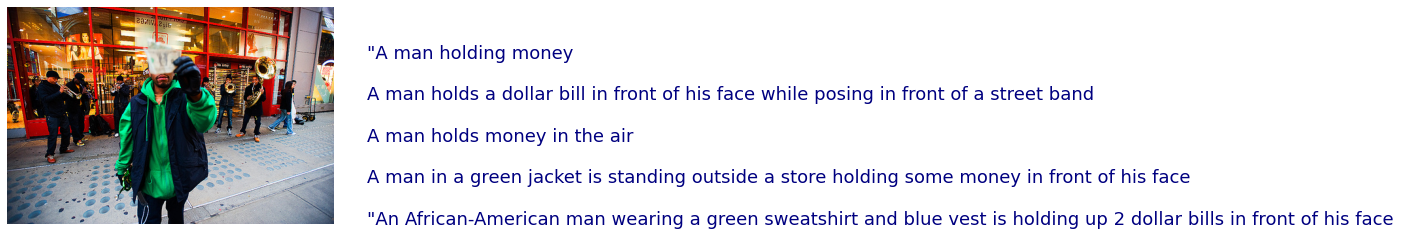

In [31]:
def caption_with_img_plot(image_id, frame) :
  #get the captions
  capt = ("\n" *2).join(frame[frame['ID'] == image_id].Captions.to_list())
  fig, ax = plt.subplots()
  ax.set_axis_off()
  idx = df.ID.to_list().index(image_id)
  im =  Image.open(df.Path.iloc[idx])
  w, h = im.size[0], im.size[-1]
  ax.imshow(im)
  ax.text(w+50, h, capt, fontsize = 18, color = 'navy')
caption_with_img_plot(df.ID.iloc[8049], df)

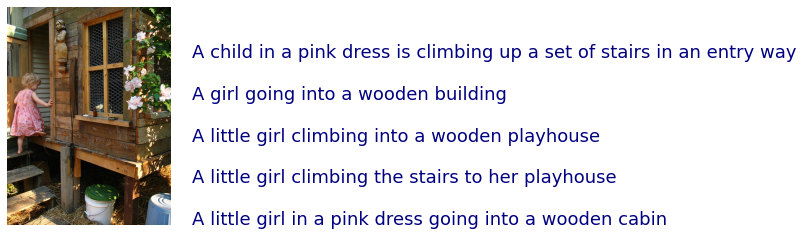

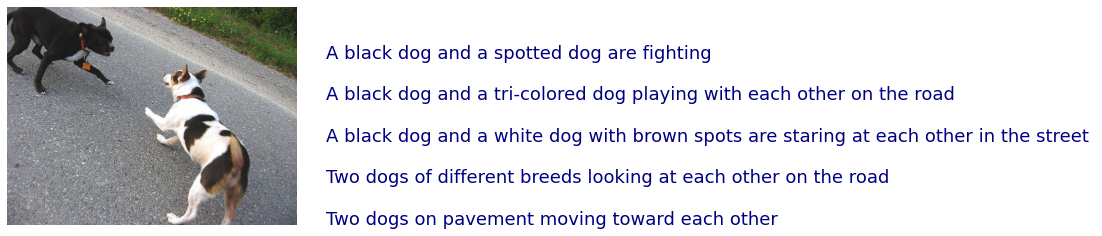

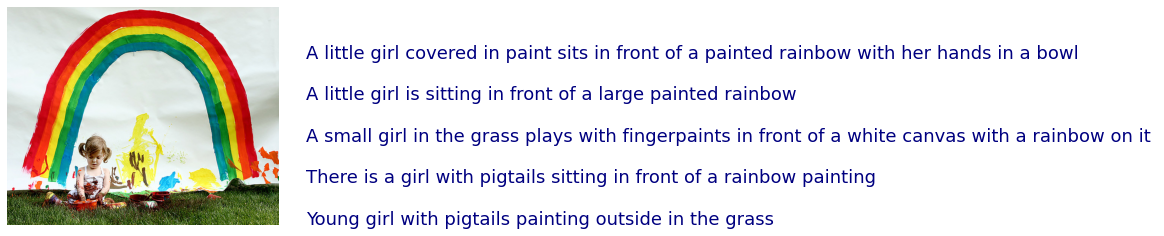

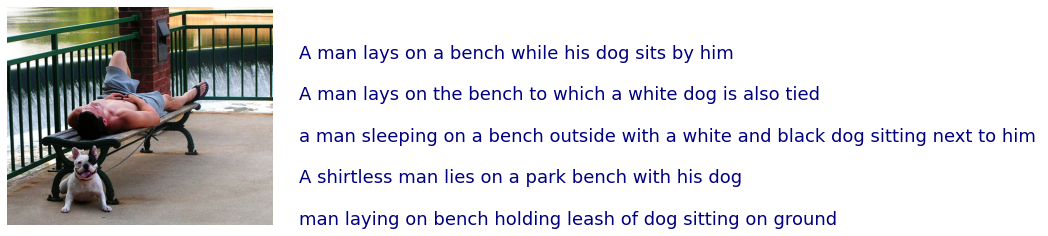

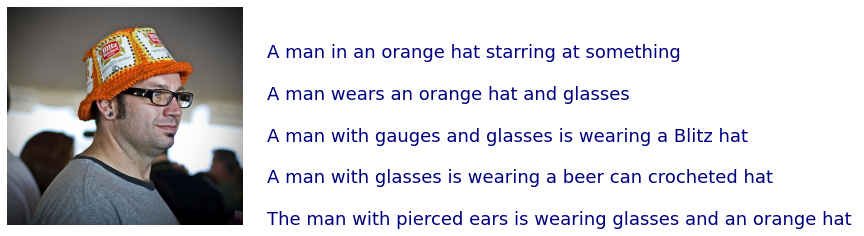

In [32]:
def execute_img_capt(start, end, frame) :
  for r in range(start, end) :
    caption_with_img_plot(frame.ID.drop_duplicates().iloc[r], frame)

execute_img_capt(0, 5, df)  

In [33]:
#data cleaning
rem_punct = str.maketrans('', '', string.punctuation)
for r in range(len(annotations)) :
  line = annotations[r]
  line = line.split()

  # converting to lowercase
  line = [word.lower() for word in line]

  # remove punctuation from each caption and hanging letters
  line = [word.translate(rem_punct) for word in line]
  line = [word for word in line if len(word) > 1]

  # remove numeric values
  line = [word for word in line if word.isalpha()]

  annotations[r] = ' '.join(line)


In [34]:
annotations = ['<start>' + ' ' + line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector

# create the tokenizer
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')

# Create word-to-index and index-to-word mappings.
tokenizer.fit_on_texts(annotations)

#transform each text into a sequence of integers
train_seqs = tokenizer.texts_to_sequences(annotations)
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


<ipython-input-44-2b575bb29661>:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


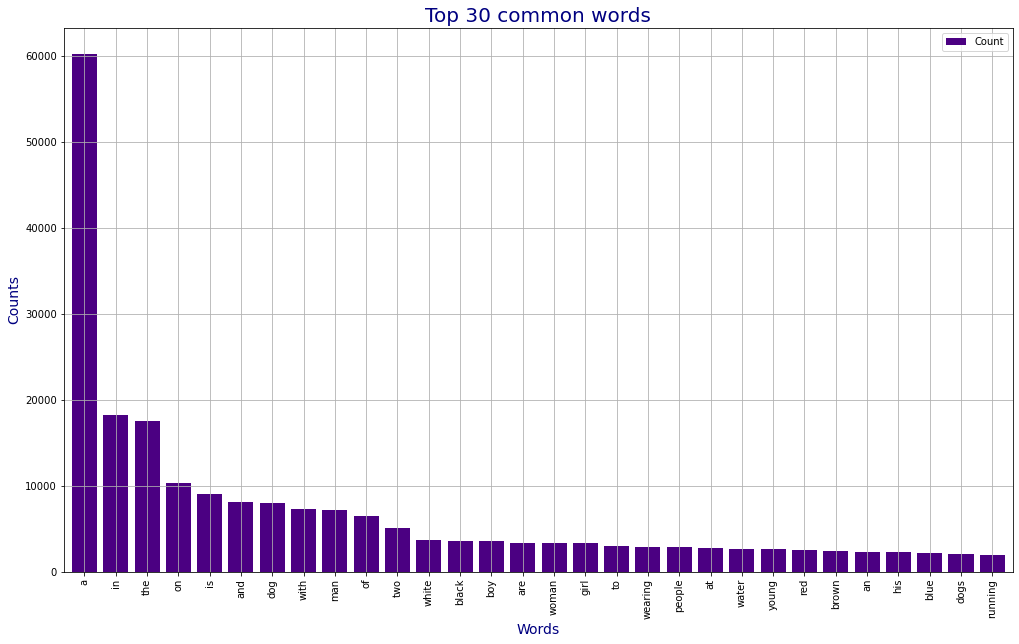

In [44]:
tokenizer_top_words = [word for line in annotations for word in line.split() ]
tokenizer_top_words_count = collections.Counter(tokenizer_top_words)

for word, count in tokenizer_top_words_count.most_common(30) :
  print(word, ": ", count)

tokens = tokenizer_top_words_count.most_common(30)
most_com_words_df = pd.DataFrame(tokens, columns = ['Word', 'Count'])

#plot 30 most common words
most_common_words_df.plot.bar(x = 'Word', y= 'Count', width=0.8, color = 'indigo', figsize = (17, 10))
plt.title('Top 30 common words', fontsize =20, color= 'navy')
plt.xlabel('Words', fontsize =14, color= 'navy')
plt.ylabel('Counts', fontsize =14, color= 'navy')
plt.grid(b=None)

In [45]:
#store the length of all lists
train_seqs_len = [len(seq) for seq in train_seqs]

#store elements from list with maximum value
longest_word_length = max(train_seqs_len)

#calculate longest word_length and pads all sequences to equal length as that of the longest.
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 31)


In [48]:
# creating list to store preprocessed images and setting up the Image Shape
preprocessed_image = []
IMAGE_SHAPE = (299, 299)

for img in all_imgs[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    preprocessed_image.append(img)

In [50]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [52]:
## sort the unique paths and store in a list
training_list = sorted(set(all_img_vector))

#create a new dataset from above training list
New_Img = tf.data.Dataset.from_tensor_slices(training_list)

#map load_images function across the elements of the new dataset above
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)

#setting a batch size of 64
New_Img = New_Img.batch(64, drop_remainder=False)
#Note : As we don't want to drop the last batch if it contains less than 64 elements, we set drop_remainder to false

### Train-test split
    Split ratio = 80 : 20
    Rabdom state = 42

In [54]:
path_train, path_test, caption_train, caption_test = train_test_split(all_img_vector, cap_vector, test_size = 0.2, random_state = 42)

In [55]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [56]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 60s 1us/step


In [57]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   12288       ['max_pooling2d_1[0][0]']        
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   16384       ['average_pooling2d_1[0][0]']    
                                64)                                                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, None, None,   192        ['conv2d_12[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_normalization_14 (BatchN  (None, None, None,   192        ['conv2d_14[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_25 (BatchN  (None, None, None,   192        ['conv2d_25[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_19 (Activation)     (None, None, None,   0           ['batch_normalization_19[0][0]'] 
                                64)                                                               
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_21[0][0]'] 
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   114688      ['activation_35[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_31 (BatchN  (None, None, None,   384        ['conv2d_31[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   384        ['conv2d_36[0][0]']              
 ormalization)                  128)                                                              
          

 ormalization)                  160)                                                              
                                                                                                  
 activation_44 (Activation)     (None, None, None,   0           ['batch_normalization_44[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   179200      ['activation_44[0][0]']          
                                160)                                                              
                                                                                                  
 batch_normalization_45 (BatchN  (None, None, None,   480        ['conv2d_45[0][0]']              
 ormalization)                  160)                                                              
          

 activation_48 (Activation)     (None, None, None,   0           ['batch_normalization_48[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_49 (Activation)     (None, None, None,   0           ['batch_normalization_49[0][0]'] 
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_40[0][0]',          
                                768)                              'activation_43[0][0]',          
                                                                  'activation_48[0][0]',          
                                                                  'activation_49[0][0]']          
          

 batch_normalization_53 (BatchN  (None, None, None,   576        ['conv2d_53[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_58 (BatchN  (None, None, None,   576        ['conv2d_58[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_59 (BatchN  (None, None, None,   576        ['conv2d_59[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
          

 conv2d_60 (Conv2D)             (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   258048      ['activation_62[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_68 (Conv2D)             (None, None, None,   258048      ['activation_67[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_69 (Conv2D)             (None, None, None,   147456      ['average_pooling2d_6[0][0]']    
          

 batch_normalization_71 (BatchN  (None, None, None,   960        ['conv2d_71[0][0]']              
 ormalization)                  320)                                                              
                                                                                                  
 batch_normalization_75 (BatchN  (None, None, None,   576        ['conv2d_75[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_71 (Activation)     (None, None, None,   0           ['batch_normalization_71[0][0]'] 
                                320)                                                              
                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_75[0][0]'] 
          

                                384)                                                              
                                                                                                  
 activation_79 (Activation)     (None, None, None,   0           ['batch_normalization_79[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_82 (Activation)     (None, None, None,   0           ['batch_normalization_82[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_83[0][0]'] 
                                384)                                                              
          

 ormalization)                  384)                                                              
                                                                                                  
 batch_normalization_92 (BatchN  (None, None, None,   1152       ['conv2d_92[0][0]']              
 ormalization)                  384)                                                              
                                                                                                  
 conv2d_93 (Conv2D)             (None, None, None,   393216      ['average_pooling2d_8[0][0]']    
                                192)                                                              
                                                                                                  
 batch_normalization_85 (BatchN  (None, None, None,   960        ['conv2d_85[0][0]']              
 ormalization)                  320)                                                              
          

In [58]:
# extract features from each image in the dataset
img_features = {}
for image, image_path in tqdm(New_Img) :
  # we are using tqdm for progress bar

  # feed images from newly created Dataset above to Inception V3 built above
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [19:07<00:00,  9.03s/it]


In [59]:
batch_features

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.0000000e+00, 7.7467650e-02, 0.0000000e+00, ...,
          2.3183759e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.0778813e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 1.9403169e-01, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.8575513e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          9.4265595e-02, 0.0000000e+00, 5.0578970e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 4.2300537e-01, 1.3446197e-02, ...,
          2.3367137e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          4.9979120e-02, 0.0000000e+00, 0.0000000e+00]

In [60]:
batch_features_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.7467650e-02, 0.0000000e+00, ...,
         2.3183759e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0778813e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9403169e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8575513e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6569363e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0261021e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.1791839e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5347540e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2506025e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.8497171e-02, ...,
         1.2064208e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [67]:
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [68]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    # dataset created using tf.data.Dataset.from_tensor_slices
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [69]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [70]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 31)


In [71]:
# Setting  parameters
embedding_dim = 256 
units = 512

#top 5,000 words +1
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE  #len(total test images) // BATCH_SIZE

max_length = 31
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [72]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [73]:
#Building Encoder using CNN Keras subclassing method
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [75]:
encoder=Encoder(embedding_dim)

In [76]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)

        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = hidden[:, tf.newaxis]

        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  

        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 

        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features 

        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        
        return context_vector, attention_weights

In [77]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [78]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [79]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


In [80]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [81]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [82]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [83]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [84]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        encoder_op = encoder(img_tensor)

        #apply teacher forcing by passing target word as next input to the decoder
        for r in range(1, target.shape[1]) :
          #pass encoder_op to decoder
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1]))
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars)
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [85]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)

      #apply teacher forcing
      for r in range(1, target.shape[1]) :
        #pass encoder_op to decoder
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)

    avg_loss = (loss/ int(target.shape[1]))
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars)
    optimizer.apply_gradients(zip(grad, trainable_vars))                      
    return loss, avg_loss

In [86]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps
    return avg_test_loss

In [87]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.440, & test loss is 1.206
Time taken for 1 epoch 2171.632473707199 sec

Test loss has been reduced from 100.000 to 1.206


  7%|█████▎                                                                         | 1/15 [36:15<8:27:30, 2175.02s/it]

For epoch: 2, the train loss is 1.113, & test loss is 1.057
Time taken for 1 epoch 1704.566014289856 sec

Test loss has been reduced from 1.206 to 1.057


 13%|██████████▎                                                                  | 2/15 [1:04:51<6:52:45, 1905.02s/it]

For epoch: 3, the train loss is 1.005, & test loss is 0.971
Time taken for 1 epoch 1317.3456933498383 sec

Test loss has been reduced from 1.057 to 0.971


 20%|███████████████▍                                                             | 3/15 [1:26:52<5:27:40, 1638.38s/it]

For epoch: 4, the train loss is 0.932, & test loss is 0.906
Time taken for 1 epoch 1319.9698057174683 sec

Test loss has been reduced from 0.971 to 0.906


 27%|████████████████████▌                                                        | 4/15 [1:48:54<4:37:31, 1513.79s/it]

For epoch: 5, the train loss is 0.870, & test loss is 0.847
Time taken for 1 epoch 1326.9239089488983 sec

Test loss has been reduced from 0.906 to 0.847


 33%|█████████████████████████▋                                                   | 5/15 [2:11:05<4:01:18, 1447.81s/it]

For epoch: 6, the train loss is 0.818, & test loss is 0.799
Time taken for 1 epoch 1350.354377746582 sec

Test loss has been reduced from 0.847 to 0.799


 40%|██████████████████████████████▊                                              | 6/15 [2:33:45<3:32:40, 1417.86s/it]

For epoch: 7, the train loss is 0.771, & test loss is 0.753
Time taken for 1 epoch 1358.574829339981 sec

Test loss has been reduced from 0.799 to 0.753


 47%|███████████████████████████████████▉                                         | 7/15 [2:56:40<3:07:09, 1403.69s/it]

For epoch: 8, the train loss is 0.728, & test loss is 0.709
Time taken for 1 epoch 1336.2992861270905 sec

Test loss has been reduced from 0.753 to 0.709


 53%|█████████████████████████████████████████                                    | 8/15 [3:19:05<2:41:36, 1385.18s/it]

For epoch: 9, the train loss is 0.686, & test loss is 0.668
Time taken for 1 epoch 1334.597431898117 sec

Test loss has been reduced from 0.709 to 0.668


 60%|██████████████████████████████████████████████▏                              | 9/15 [3:41:28<2:17:12, 1372.05s/it]

For epoch: 10, the train loss is 0.648, & test loss is 0.631
Time taken for 1 epoch 1371.2559523582458 sec

Test loss has been reduced from 0.668 to 0.631


 67%|██████████████████████████████████████████████████▋                         | 10/15 [4:04:28<1:54:31, 1374.29s/it]

For epoch: 11, the train loss is 0.614, & test loss is 0.598
Time taken for 1 epoch 1361.1620273590088 sec

Test loss has been reduced from 0.631 to 0.598


 73%|███████████████████████████████████████████████████████▋                    | 11/15 [4:27:17<1:31:30, 1372.65s/it]

For epoch: 12, the train loss is 0.581, & test loss is 0.567
Time taken for 1 epoch 1364.6685180664062 sec

Test loss has been reduced from 0.598 to 0.567


 80%|████████████████████████████████████████████████████████████▊               | 12/15 [4:50:09<1:08:37, 1372.56s/it]

For epoch: 13, the train loss is 0.552, & test loss is 0.538
Time taken for 1 epoch 1392.4079372882843 sec

Test loss has been reduced from 0.567 to 0.538


 87%|███████████████████████████████████████████████████████████████████▌          | 13/15 [5:13:26<46:00, 1380.08s/it]

For epoch: 14, the train loss is 0.525, & test loss is 0.507
Time taken for 1 epoch 1382.6103148460388 sec

Test loss has been reduced from 0.538 to 0.507


 93%|████████████████████████████████████████████████████████████████████████▊     | 14/15 [5:36:37<23:03, 1383.33s/it]

For epoch: 15, the train loss is 0.502, & test loss is 0.487
Time taken for 1 epoch 1389.2654626369476 sec

Test loss has been reduced from 0.507 to 0.487


100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [5:59:55<00:00, 1439.71s/it]


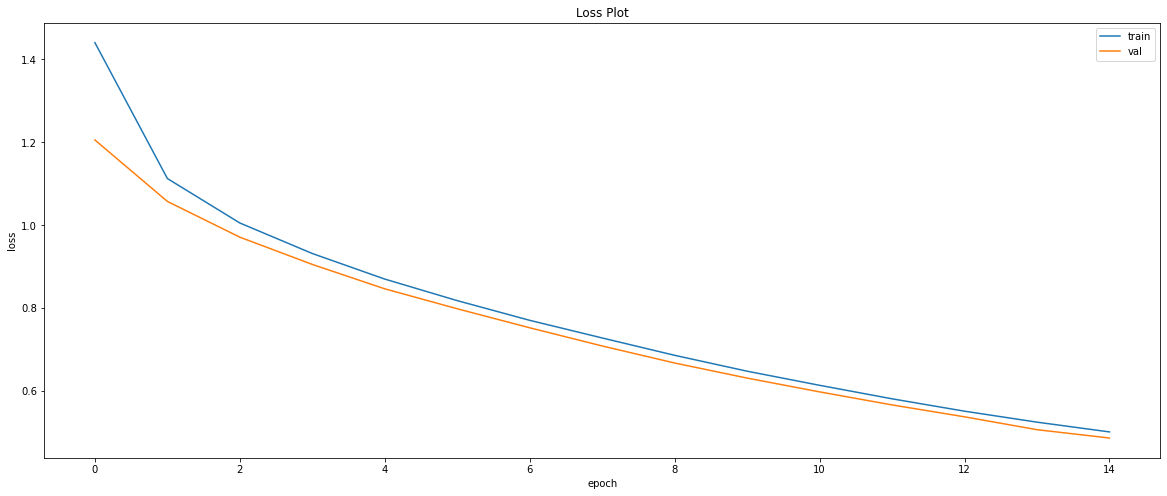

In [113]:
from matplotlib.pyplot import figure
figure(figsize=(20, 8))
plt.plot(loss_plot, label = 'train')
plt.plot(test_loss_plot, label = 'val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [89]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))
    hidden = decoder.init_state(batch_size=1)
    temp_input = tf.expand_dims(load_images(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder (img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append (tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [90]:
def plot_attention_map (caption, weights, image) :
  fig = plt.figure(figsize = (10, 10))
  temp_img = np.array(Image.open(image))
  cap_len = len(caption)
  for cap in range(cap_len) :
    weights_img = np.reshape(weights[cap], (8,8))
    wweights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.LANCZOS))
    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap], fontsize = 14, color = 'red')
    img = ax.imshow(temp_img)
    ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [92]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [93]:
image_test = path_test.copy()

In [133]:
def pred_caption_audio(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :

    cap_test_data = caption_test.copy()
    rid = np.random.randint(0, random)
#     test_image = image_test[rid]
    test_image = './images/512026551_ba63ddbd31.jpg'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, test_image)

    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    return test_image


# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 1</p>

BLEU score: 6.10669334877734e-76
Real Caption: man demonstrating his black and white dog performing back flip
Prediction Caption: man and dog are walking on the grass with very long leash attached to black flags


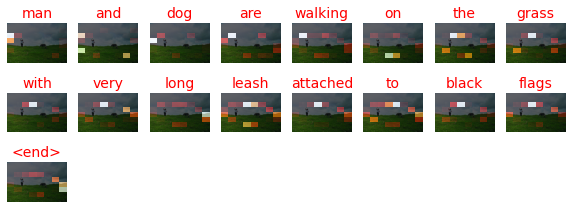

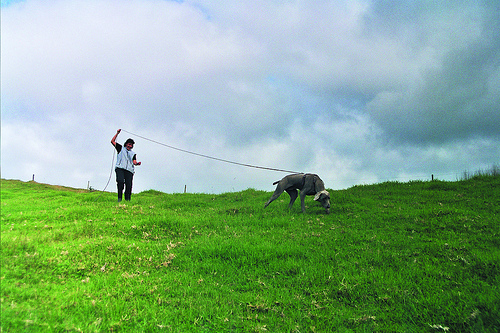

In [115]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 2</p>

BLEU score: 4.3180842775472395e-76
Real Caption: the kayaker is going through rapids
Prediction Caption: man wearing yellow suit is standing in snow


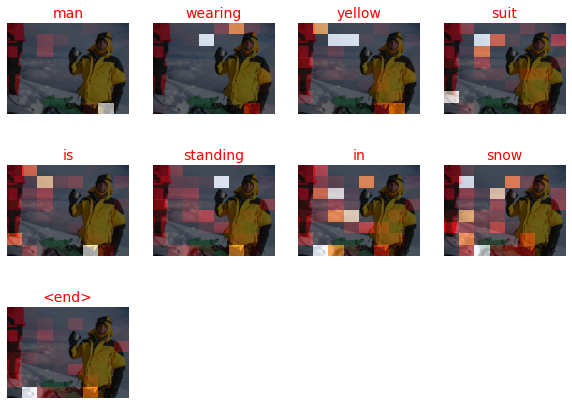

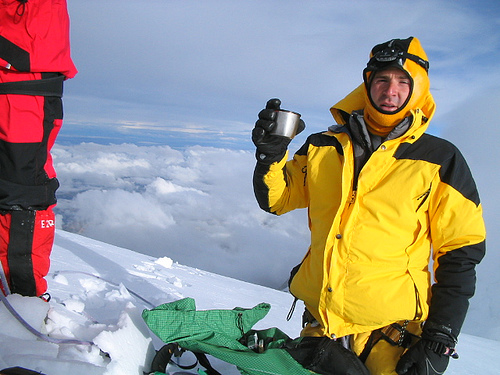

In [117]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 3</p>

BLEU score: 4.252809007923282e-76
Real Caption: this brown pitbull is carrying soccer ball in his mouth
Prediction Caption: brown dog is walking through the water


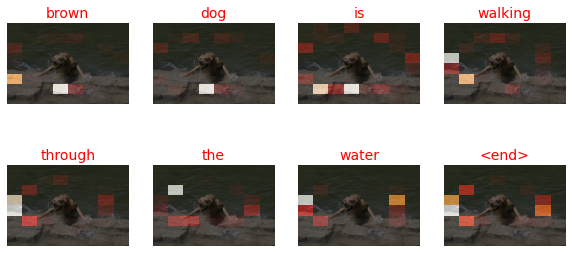

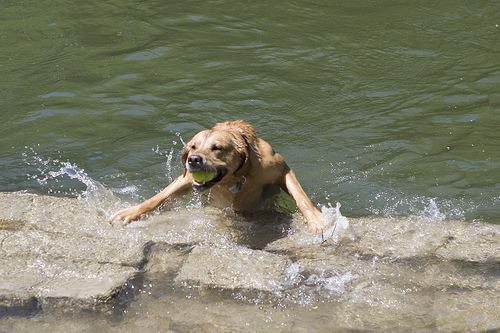

In [134]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 4</p>

BELU score: 16.529888822158657
Real Caption: two men are playing basketball and one is trying to block the others shot
Prediction Caption: two men are playing basketball


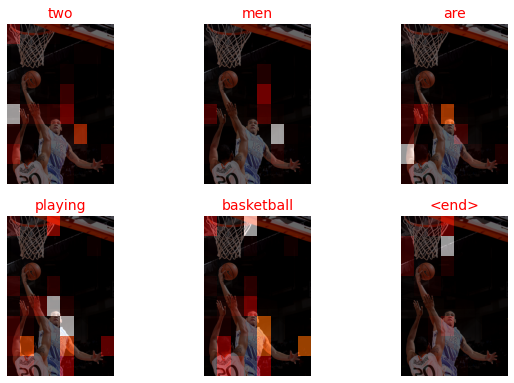

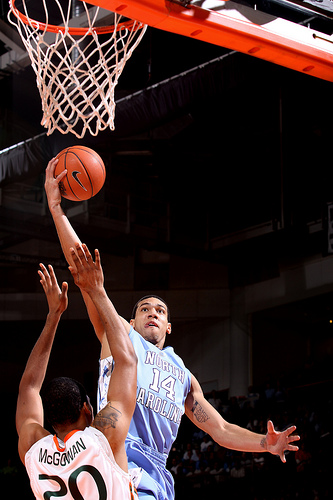

In [110]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.25, 0.25, 0, 0))
Image.open(test_image)